In [2]:
# -------------------------------------------------
# Task 2.2 – Cross-country comparison of HICP
# Requirements: pip install fredapi pandas matplotlib
# -------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

# 1. Load FRED API key from file and create a Fred object
with open("fredapi_key.txt", "r") as f:
    fred = Fred(api_key=f.read().strip())

FileNotFoundError: [Errno 2] No such file or directory: 'fredapi_key.txt'

In [3]:
# 2. Series codes for HICP (All Items), by country/area
SERIES_CODES = {
    "Denmark": "CP0000DKM086NEST",
    "Austria": "CP0000ATM086NEST",
    "Euro Area": "CP0000EZCCM086NEST",   # Euro Area HICP (All Items)
    "United States": "CP0000USM086NEST", # Harmonized CPI for the US
}

# Helper function: download a series safely and return as pandas Series
def fetch_series(series_id: str) -> pd.Series:
    sid = series_id.strip().upper()  # remove hidden whitespace/newlines
    s = fred.get_series(sid)
    s.name = sid
    return s

# 3. Download all series into one DataFrame
data_columns = {}
for region, sid in SERIES_CODES.items():
    s = fetch_series(sid)
    s.name = region  # rename column to readable label
    data_columns[region] = s

hicp = pd.concat(data_columns.values(), axis=1)

NameError: name 'fred' is not defined

In [3]:
# Ensure datetime index
hicp.index = pd.to_datetime(hicp.index)

# Keep only observations from 2019 onward
hicp = hicp.loc[hicp.index >= "2019-01-01"]

# 4. Compute 12-month (year-over-year) inflation rates
# Formula: inflation_t = (HICP_t / HICP_{t-12} - 1) * 100
inflation_yoy = hicp.pct_change(periods=12) * 100

/var/folders/4c/1ss308gn5cjfp7yk68sdqn9m0000gn/T/ipykernel_17254/1099468422.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  inflation_yoy = hicp.pct_change(periods=12) * 100


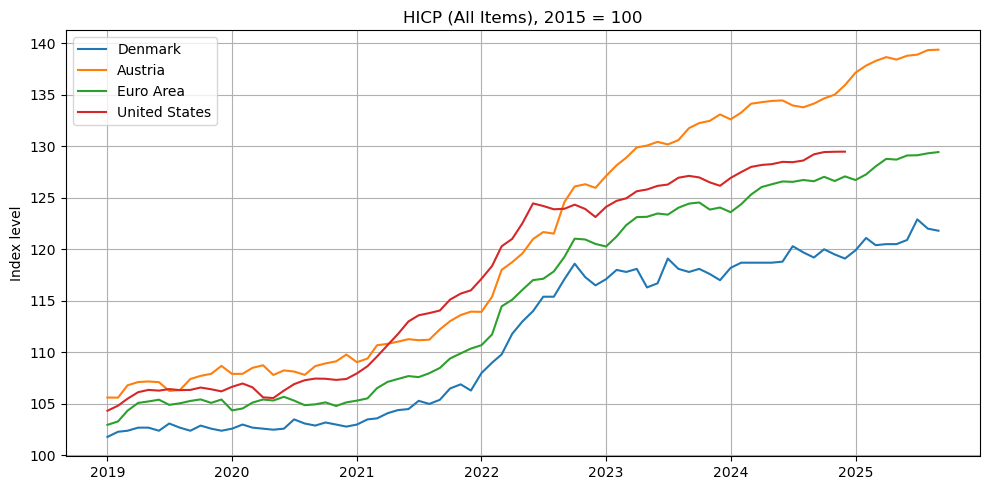

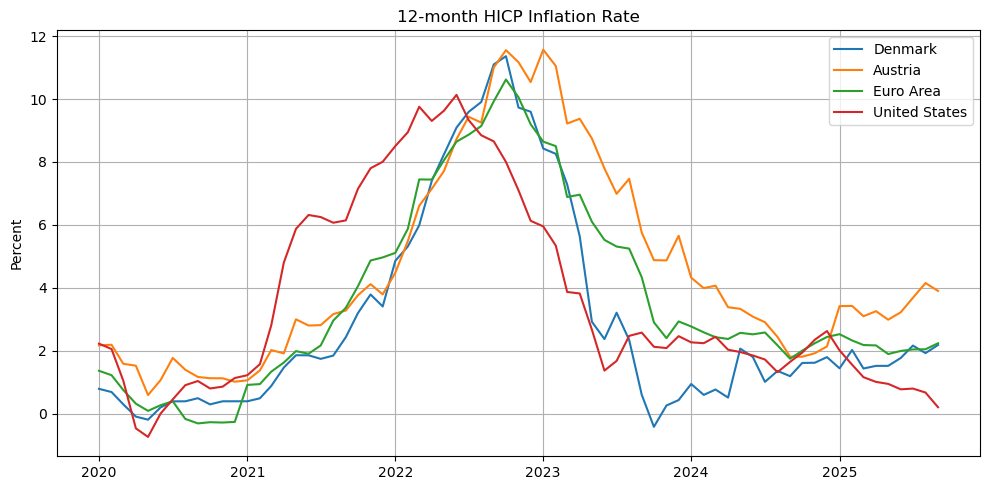

In [4]:
# 5. Plot HICP index levels
plt.figure(figsize=(10,5))
for country in hicp.columns:
    plt.plot(hicp.index, hicp[country], label=country)
plt.title("HICP (All Items), 2015 = 100")
plt.ylabel("Index level")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 6. Plot 12-month HICP inflation rates
plt.figure(figsize=(10,5))
for country in inflation_yoy.columns:
    plt.plot(inflation_yoy.index, inflation_yoy[country], label=country)
plt.title("12-month HICP Inflation Rate")
plt.ylabel("Percent")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# 7. Yearly summary statistics:
#    For each year and each country, compute the min, max, and mean
annual_stats = (
    inflation_yoy
    .resample("Y")          # calendar year (year-end frequency)
    .agg(["min", "max", "mean"])
    .round(2)
)

print("\n=== Yearly statistics for 12-month HICP inflation (percent) ===")
print("(Rows = year, Columns = country, Sub-columns = min / max / mean)\n")
print(annual_stats)

# 8. Average inflation since 2019 by country
avg_since_2019 = inflation_yoy.mean().round(2)
print("\n=== Average 12-month HICP inflation since 2019 (percent) ===")
print(avg_since_2019)

# 9. Text summary you can use in the write-up
print("\nSummary:")
print("- All four regions experienced a clear inflation surge in 2021–2022 compared to 2019–2020.")
print("- The United States tends to peak earlier and more sharply than the Euro Area,")
print("  suggesting stronger domestic demand pressures in the U.S. early in the period.")
print("- Denmark and Austria closely track the Euro Area pattern,")
print("  with similar timing of the energy/food shock.")
print("- After the peak, inflation declines across all regions from 2023 onward,")
print("  but the speed and level differ somewhat across countries.")


/var/folders/4c/1ss308gn5cjfp7yk68sdqn9m0000gn/T/ipykernel_17254/2111721119.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("Y")          # calendar year (year-end frequency)



=== Yearly statistics for 12-month HICP inflation (percent) ===
(Rows = year, Columns = country, Sub-columns = min / max / mean)

           Denmark              Austria              Euro Area               \
               min    max  mean     min    max  mean       min    max  mean   
2019-12-31     NaN    NaN   NaN     NaN    NaN   NaN       NaN    NaN   NaN   
2020-12-31   -0.19   0.79  0.33    0.59   2.19  1.39     -0.31   1.36  0.26   
2021-12-31    0.39   3.79  1.94    1.06   4.11  2.76      0.91   4.96  2.59   
2022-12-31    4.85  11.36  8.51    4.48  11.55  8.59      5.11  10.62  8.36   
2023-12-31   -0.42   8.43  3.44    4.87  11.57  7.78      2.40   8.64  5.48   
2024-12-31    0.51   2.06  1.27    1.81   4.32  2.93      1.74   2.77  2.37   
2025-12-31    1.43   2.18  1.77    2.98   4.15  3.46      1.89   2.52  2.15   

           United States               
                     min    max  mean  
2019-12-31           NaN    NaN   NaN  
2020-12-31         -0.74   2.22  0.77

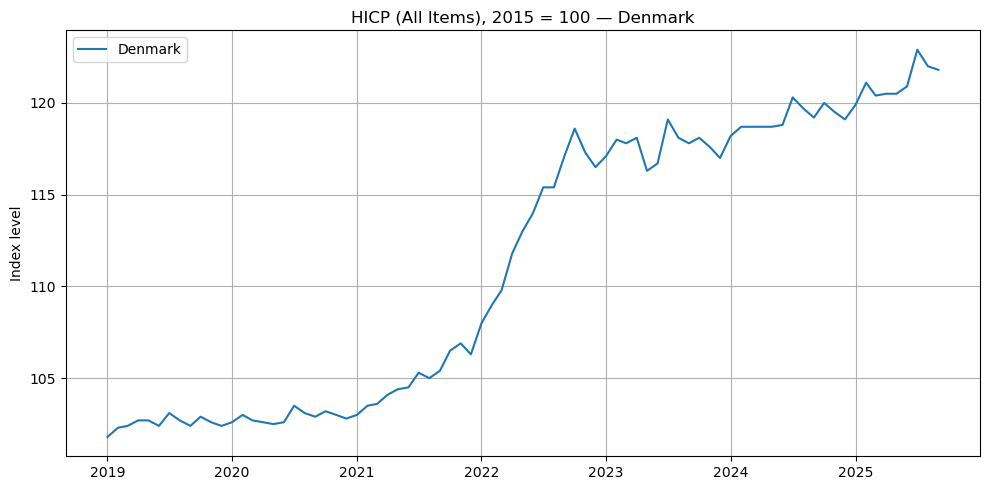

In [6]:
plt.figure(figsize=(10,5))
plt.plot(hicp.index, hicp["Denmark"], label="Denmark")
plt.title("HICP (All Items), 2015 = 100 — Denmark")
plt.ylabel("Index level")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [1]:
# C. Merge wages and prices at quarterly frequency (English labels)

# Rename columns to English-friendly names first
df_q = pd.concat(
    [
        dk_wage_q.rename(columns={"DK_wage_index_2015eq100": "Hourly_wage_index_2015eq100"}),
        dk_hicp_q.rename(columns={"DK_hicp_index_2015eq100": "Consumer_price_index_2015eq100"}),
    ],
    axis=1,
    join="inner"
).dropna()

# D. Real wage index

df_q["Real_wage_index_2015eq100"] = (
    df_q["Hourly_wage_index_2015eq100"] / df_q["Consumer_price_index_2015eq100"] * 100
)

# Rebase real wages so that the 2019 average = 100
base_2019 = df_q.loc[df_q.index.year == 2019, "Real_wage_index_2015eq100"].mean()
df_q["Real_wage_index_2019avg100"] = (
    df_q["Real_wage_index_2015eq100"] / base_2019 * 100
)

# E. Figure 1: Nominal wages vs consumer prices

plt.figure(figsize=(10,5))
plt.plot(
    df_q.index,
    df_q["Hourly_wage_index_2015eq100"],
    label="Hourly wage (private sector), 2015=100"
)
plt.plot(
    df_q.index,
    df_q["Consumer_price_index_2015eq100"],
    label="Consumer prices (HICP), 2015=100"
)
plt.title("Denmark: Wages vs Prices (quarterly)")
plt.ylabel("Index (2015=100)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# F. Figure 2: Real wages (purchasing power)

plt.figure(figsize=(10,5))
plt.plot(
    df_q.index,
    df_q["Real_wage_index_2019avg100"],
    label="Real hourly wage (2019=100)"
)
plt.title("Denmark: Real Wages (hourly wage deflated by consumer prices)")
plt.ylabel("Index (2019=100)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'pd' is not defined

In [ ]:
# === Assignment 1.4 — Disaggregated inflation (PRIS111) ===
# Goal:
# 1. Get the detailed CPI panel by product category from PRIS111
# 2. List all detailed categories
# 3. Cross-sectional dispersion of 12-month inflation (25/50/75 percentiles)
# 4. Histogram of cumulative price changes since Aug 2020
# 5. Top/bottom 10 categories


import pandas as pd
import matplotlib.pyplot as plt


# --------------------------------------------------------
# Helper functions (reuse logic from 1.3)
# --------------------------------------------------------

def pick_enhed_id(v: dict) -> str:
    """
    Choose an ENHED (unit) that represents an index level, not a pct change.
    Prefer something that looks like an index with base '=100' or '2015=100'.
    Fallback: the first available value.
    """
    bad_words = ("pct", "procent", "ændring", "aendring", "change", "%")
    candidates = []
    for val in v.get("values", []):
        txt = (val.get("text", "") or "")
        txt_l = txt.lower()
        if (
            ("index" in txt_l or "=100" in txt_l or "2015" in txt_l or "100" in txt_l)
            and not any(b in txt_l for b in bad_words)
        ):
            # score: prefer explicit base info
            score = 2 * ("2015" in txt_l) + ("=100" in txt_l or "100" in txt_l)
            candidates.append((score, val["id"], txt))
    if candidates:
        candidates.sort(reverse=True)  # best score first
        best = candidates[0]
        return best[1]

    # fallback: just take the first value
    return v["values"][0]["id"]


def pick_season_id(v: dict) -> str:
    """
    Prefer 'not seasonally adjusted' if available.
    Fallback: first available value.
    """
    for val in v.get("values", []):
        txt = (val.get("text", "") or "").lower()
        if "ikke sæson" in txt or "not season" in txt or "not seasonally" in txt:
            return val["id"]
    return v["values"][0]["id"]


# --------------------------------------------------------
# STEP 0. Fetch full CPI panel from PRIS111 at product-group level
# PRIS113 is headline aggregates. PRIS111 is detailed by product group (VAREGR),
# which is what we need here.
# --------------------------------------------------------

api = DstApi("PRIS111")
meta = api.tableinfo(language="da")  # 'da' because column labels etc. come from DST in Danish

# Identify the time variable in metadata
time_var = meta.get("time")
if time_var is None:
    # fallback: search manually
    for v in meta.get("variables", []):
        vid = (v.get("id", "") or "").lower()
        vtxt = (v.get("text", "") or "").lower()
        if any(k in vtxt for k in ("tid", "time", "måned", "maaned", "month", "periode")):
            time_var = v
            break
time_code = time_var["id"] if time_var is not None else "TID"

# Identify product group variable (VAREGR)
varegr_var = next(
    (v for v in meta["variables"] if v.get("id", "").upper() == "VAREGR"),
    None
)
if varegr_var is None:
    raise RuntimeError("Could not find VAREGR in PRIS111 metadata.")
varegr_code = varegr_var["id"]

# Identify ENHED (unit / index definition, like '2015=100')
enhed_var = next(
    (
        v for v in meta["variables"]
        if "ENHED" in v.get("id", "").upper()
        or "enhed" in v.get("text", "").lower()
        or "unit"  in v.get("text", "").lower()
    ),
    None
)

# Identify a seasonal-adjustment dimension if present
season_var = next(
    (
        v for v in meta["variables"]
        if "sæson" in v.get("text", "").lower()
        or "saeson" in v.get("text", "").lower()
        or "season" in v.get("text", "").lower()
    ),
    None
)

# Build the variables payload for the API call.
# We want:
# - VAREGR: all product groups ("*")
# - ENHED: pick one index level definition (not % change)
# - Season: pick "not seasonally adjusted" if available
# - Time: all months
variables_payload = []
for v in meta["variables"]:
    code = v["id"]
    if code == time_code:
        continue
    if code == varegr_code:
        variables_payload.append({"code": code, "values": ["*"]})
    elif enhed_var is not None and code == enhed_var["id"]:
        variables_payload.append({"code": code, "values": [pick_enhed_id(enhed_var)]})
    elif season_var is not None and code == season_var["id"]:
        variables_payload.append({"code": code, "values": [pick_season_id(season_var)]})
    else:
        # Any other dimension: just take the first available value
        first_val = v["values"][0]["id"] if v.get("values") else "*"
        variables_payload.append({"code": code, "values": [first_val]})

# Add the time dimension (all periods)
variables_payload.append({"code": time_code, "values": ["*"]})

params = {
    "table": "PRIS111",
    "format": "CSV",
    "lang": "da",   # keep Danish labels; numeric content isn't affected
    "variables": variables_payload,
}

raw = api.get_csv(params)


# --------------------------------------------------------
# STEP 1. Clean data (date, category text, numeric index level)
# --------------------------------------------------------

# Find likely column names for time and value
time_col = next(
    c for c in raw.columns
    if c.lower() in ("tid", "time", "måned", "maaned", "month", "periode")
)

value_col = next(
    c for c in raw.columns
    if c.lower() in ("indhold", "value", "values", "data")
)

# PRIS111 should also give a column "VAREGR"
df = raw[[time_col, "VAREGR", value_col]].copy()
df.rename(
    columns={
        time_col: "date_raw",
        "VAREGR": "category",
        value_col: "level_raw",
    },
    inplace=True,
)

# Parse the DST time labels into pandas Timestamps using your existing helper
df["date"] = parse_time_column(df["date_raw"])

# Parse numeric levels robustly (Danish decimal commas / thousands separators)
if pd.api.types.is_numeric_dtype(df["level_raw"]):
    df["level"] = df["level_raw"].astype(float)
else:
    df["level"] = (
        df["level_raw"]
        .astype(str)
        .str.replace(".", "", regex=False)   # remove thousands separator dot
        .str.replace(",", ".", regex=False)  # decimal comma -> dot
        .pipe(pd.to_numeric, errors="coerce")
    )

# Extract a clean product code prefix from the category text.
# Examples:
#   "01.1.1.1 Bread"            -> cat_code "01.1.1.1"
#   "04.5.1 Electricity"        -> cat_code "04.5.1"
# We allow multiple dot groups, e.g. \d{2} then .\d etc.
df["cat_code"] = df["category"].str.extract(r"^(\d{2}(?:\.\d+)+)")

# Keep only rows that correspond to an actual product code
df_det = df[df["cat_code"].notna()].copy()


# --------------------------------------------------------
# 1.4.1 List all detailed product categories
# --------------------------------------------------------

cat_list = (
    df_det[["cat_code", "category"]]
    .drop_duplicates()
    .sort_values("cat_code")
    .reset_index(drop=True)
)

print("Detailed CPI product categories (code + label):")
for row in cat_list.itertuples(index=False):
    print(f"{row.cat_code}  {row.category}")


# --------------------------------------------------------
# 1.4.2 Cross-sectional dispersion of 12-month inflation
#      We compute YoY inflation for each product group, then
#      take the 25th/50th/75th percentiles across groups each month.
# --------------------------------------------------------

# Sort by (cat_code, date) so pct_change(12) works as intended
df_det = df_det.sort_values(["cat_code", "date"])
df_det["yoy_pct"] = (
    df_det.groupby("cat_code")["level"]
    .pct_change(12) * 100.0
)

# For each month, compute percentiles of YoY across categories
quantiles = (
    df_det
    .dropna(subset=["yoy_pct"])
    .groupby("date")["yoy_pct"]
    .agg(
        p25=lambda s: s.quantile(0.25),
        p50="median",
        p75=lambda s: s.quantile(0.75),
    )
    .reset_index()
    .sort_values("date")
)

plt.figure(figsize=(10,6))
plt.plot(quantiles["date"], quantiles["p25"], label="25th percentile")
plt.plot(quantiles["date"], quantiles["p50"], label="50th percentile (median)")
plt.plot(quantiles["date"], quantiles["p75"], label="75th percentile")
plt.axhline(2, linestyle="--")
plt.title("Cross-section of 12-month inflation across CPI categories (PRIS111)")
plt.xlabel("Date")
plt.ylabel("Percent")
plt.legend()
plt.tight_layout()
plt.show()

# Write-up guidance:
# - The median shows the 'typical' category's inflation.
# - The gap between 75th and 25th shows how broad or narrow the price pressure is.
# - If all three lines come down toward ~2%, that means inflation is cooling broadly.


# --------------------------------------------------------
# 1.4.3 Histogram of cumulative price changes
#      from Aug 2020 to Aug 2025 (or latest available month)
# --------------------------------------------------------

start_month = pd.Timestamp("2020-08-01")
target_month_guess = pd.Timestamp("2025-08-01")

# Pivot to wide: rows = category code, columns = dates, values = price index level
wide_levels = (
    df_det.pivot_table(
        index="cat_code",
        columns="date",
        values="level",
        aggfunc="first",
    )
)

if start_month not in wide_levels.columns:
    raise RuntimeError("Start month 2020-08 was not found in the dataset. Pick another start month.")

if target_month_guess in wide_levels.columns:
    end_month = target_month_guess
else:
    end_month = wide_levels.columns.max()

# Total cumulative % change over the window
pct_change_total = (
    (wide_levels[end_month] / wide_levels[start_month] - 1.0) * 100.0
).dropna()

plt.figure(figsize=(9,5))
plt.hist(pct_change_total, bins=30, edgecolor="black")
plt.title(f"Price change by category: {start_month:%Y-%m} → {end_month:%Y-%m}")
plt.xlabel("Percent change")
plt.ylabel("Number of categories")
plt.tight_layout()
plt.show()

# Write-up guidance:
# - A fat right tail means a few categories exploded in price.
# - If most mass sits around, say, +10–20%, that means broad moderate increases.
# - This tells you if inflation was driven by a few outliers or was broad-based.


# --------------------------------------------------------
# 1.4.4 Top 10 and bottom 10 categories
#      Rank categories by total price change since Aug 2020.
# --------------------------------------------------------

# Build a lookup from cat_code -> human-readable category text
name_lookup = (
    df_det[["cat_code", "category"]]
    .drop_duplicates(subset=["cat_code"])
    .set_index("cat_code")["category"]
)

rank_df = (
    pct_change_total
    .to_frame(name="pct_change_total")
    .join(name_lookup, how="left")
    .sort_values("pct_change_total")
)

bottom10 = rank_df.head(10).copy()   # smallest price increase (or declines)
top10    = rank_df.tail(10).copy()   # largest price increases

# Bottom 10 barh
plt.figure(figsize=(10,6))
plt.barh(bottom10["category"], bottom10["pct_change_total"])
plt.title(f"Bottom 10 categories {start_month:%Y-%m} → {end_month:%Y-%m}")
plt.xlabel("Percent change")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

# Top 10 barh (sorted ascending so bars go upward nicely)
top10_sorted = top10.sort_values("pct_change_total")
plt.figure(figsize=(10,6))
plt.barh(top10_sorted["category"], top10_sorted["pct_change_total"])
plt.title(f"Top 10 categories {start_month:%Y-%m} → {end_month:%Y-%m}")
plt.xlabel("Percent change")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

# Write-up guidance:
# - The Top 10 are the categories that drove the inflation story after 2020.
# - The Bottom 10 are those with very mild increases or even falling prices.
# - Connect this to your 1.3 result: if "energy" and "food" dominate the Top 10,
#   that supports the narrative that the inflation spike was energy/food driven.
